**Goal:**
The goal of the problem is to predict whether a passenger was satisfied or not considering his/her overall experience of traveling on the Shinkansen Bullet Train.

***Dataset: ***
The problem consists of 2 separate datasets: Travel data & Survey data. Travel data has information related to passengers and attributes related to the Shinkansen train, in which they traveled. The survey data is aggregated data of surveys indicating the post-service experience. You are expected to treat both these datasets as raw data and perform any necessary data cleaning/validation steps as required.

The data has been split into two groups and provided in the Dataset folder. The folder contains both train and test data separately.

Train_Data
Test_Data

Target Variable: Overall_Experience (1 represents ‘satisfied’, and 0 represents ‘not satisfied’)

The training set can be used to build your machine-learning model. The training set has labels for the target column - Overall_Experience.

The testing set should be used to see how well your model performs on unseen data. For the test set, it is expected to predict the ‘Overall_Experience’ level for each participant.

**Data Dictionary:**
All the data is self-explanatory. The survey levels are explained in the Data Dictionary file.

Submission File Format: You will need to submit a CSV file with exactly 35,602 entries plus a header row. The file should have exactly two columns

ID
Overall_Experience (contains 0 & 1 values, 1 represents ‘Satisfied’, and 0 represents ‘Not Satisfied’)

**Evaluation Criteria:**

Accuracy Score: The evaluation metric is simply the percentage of predictions made by the model that turned out to be correct. This is also called the accuracy of the model. It will be calculated as the total number of correct predictions (True Positives + True Negatives) divided by the total number of observations in the dataset.

In other words, the best possible accuracy is 100% (or 1), and the worst possible accuracy is 0%

## **Importing the libraries and overview of the dataset**

In [1]:
# Libraries to help with reading and manipulating data
import pandas as pd
import numpy as np

# Libaries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)
# Setting the precision of floating numbers to 5 decimal points
pd.set_option("display.float_format", lambda x: "%.5f" % x)

# To tune model, get different metric scores, and split data
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    classification_report,
    precision_recall_curve
)
from sklearn import metrics

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

# To be used for data scaling and one hot encoding
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

# To impute missing values
from sklearn.impute import SimpleImputer

# To help with model building
from sklearn.linear_model import LogisticRegression

# To build classification models
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


# For tuning the model
from sklearn.model_selection import GridSearchCV

# To supress warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#This is a binary classification task to predict passenger satisfaction with the Shinkansen Bullet Train experience
surveydata_test = pd.read_csv('/content/drive/MyDrive/data science, ML,AI/Hackathon/Surveydata_test.csv')
traveldata_test = pd.read_csv('/content/drive/MyDrive/data science, ML,AI/Hackathon/Traveldata_test.csv')
surveydata_train = pd.read_csv('/content/drive/MyDrive/data science, ML,AI/Hackathon/Surveydata_train.csv')
traveldata_train = pd.read_csv('/content/drive/MyDrive/data science, ML,AI/Hackathon/Traveldata_train.csv')
sample_submission = pd.read_csv('/content/drive/MyDrive/data science, ML,AI/Hackathon/Sample_Submission.csv')

In [ ]:
# Load the Excel file with data dictionary
FILEPATH = '/content/drive/MyDrive/data science, ML,AI/Hackathon/Data_Dictionary.xlsx'

# Define the function to read all sheets from an Excel file
def read_all_sheets_from_excel(filepath):
    """Reads all sheets from an Excel file into a dictionary of DataFrames."""
    excel_file = pd.ExcelFile(filepath)
    return {sheet_name: excel_file.parse(sheet_name) for sheet_name in excel_file.sheet_names}

dataframes = read_all_sheets_from_excel(FILEPATH)
for k, v in dataframes.items():
    print('dataframe: ' + k)
    print(v.head(15))

dataframe: Travel Data
   Data Dictionary - Travel Data                      Unnamed: 1  \
0                    Column Name              Column Description   
1                             ID  The unique ID of the passenger   
2                         Gender     The gender of the passenger   
3                  Customer_Type   Loyalty type of the passenger   
4  Data Dictionary - Travel Data                             NaN   
5                    Column Name              Column Description   
6                             ID  The unique ID of the passenger   
7                         Gender     The gender of the passenger   
8                  Customer_Type   Loyalty type of the passenger   
9  Data Dictionary - Travel Data                             NaN   

                                        Unnamed: 2  
0                            Column Value Examples  
1  Continuous values like 98800001, 98800002, etc.  
2                                     Male\nFemale  
3               

In [ ]:
print("Survey Data Train Shape:", surveydata_train.shape)
print("Travel Data Train Shape:", traveldata_train.shape)
print("Survey Data Test Shape:", surveydata_test.shape)
print("Travel Data Test Shape:", traveldata_test.shape)
print("Sample Submission Shape:", sample_submission.shape)

Survey Data Train Shape: (94379, 17)
Travel Data Train Shape: (94379, 9)
Survey Data Test Shape: (35602, 16)
Travel Data Test Shape: (35602, 9)
Sample Submission Shape: (35602, 2)


In [ ]:
# Look at the head of each dataset
print("Survey Data Train:")
print(surveydata_train.head())
print("\
Travel Data Train:")
print(traveldata_train.head())
print("\
Sample Submission:")
print(sample_submission.head())

Survey Data Train:
         ID  Overall_Experience       Seat_Comfort Seat_Class  \
0  98800001                   0  Needs Improvement  Green Car   
1  98800002                   0               Poor   Ordinary   
2  98800003                   1  Needs Improvement  Green Car   
3  98800004                   0         Acceptable   Ordinary   
4  98800005                   1         Acceptable   Ordinary   

  Arrival_Time_Convenient           Catering  Platform_Location  \
0               Excellent          Excellent    Very Convenient   
1               Excellent               Poor  Needs Improvement   
2       Needs Improvement  Needs Improvement  Needs Improvement   
3       Needs Improvement                NaN  Needs Improvement   
4              Acceptable         Acceptable         Manageable   

  Onboard_Wifi_Service Onboard_Entertainment Online_Support  \
0                 Good     Needs Improvement     Acceptable   
1                 Good                  Poor           Good  

In [ ]:
# First, let's examine the target variable distribution in training data
print("Target Variable Distribution:")
print(surveydata_train['Overall_Experience'].value_counts())
print("\
Target Variable Proportions:")
print(surveydata_train['Overall_Experience'].value_counts(normalize=True))

Target Variable Distribution:
Overall_Experience
1    51593
0    42786
Name: count, dtype: int64
Target Variable Proportions:
Overall_Experience
1   0.54666
0   0.45334
Name: proportion, dtype: float64


This is a slightly imbalanced dataset (around 55:45), but not severely imbalanced, so we can:

Proceed with accuracy as the primary metric (as required)

Still monitor precision/recall/F1 if needed later

In [ ]:
# Check for missing values in both datasets
print("Missing values in Survey Train Data:")
print(surveydata_train.isnull().sum())
print("\
Missing values in Travel Train Data:")
print(traveldata_train.isnull().sum())

Missing values in Survey Train Data:
ID                            0
Overall_Experience            0
Seat_Comfort                 61
Seat_Class                    0
Arrival_Time_Convenient    8930
Catering                   8741
Platform_Location            30
Onboard_Wifi_Service         30
Onboard_Entertainment        18
Online_Support               91
Ease_of_Online_Booking       73
Onboard_Service            7601
Legroom                      90
Baggage_Handling            142
CheckIn_Service              77
Cleanliness                   6
Online_Boarding               6
dtype: int64
Missing values in Travel Train Data:
ID                            0
Gender                       77
Customer_Type              8951
Age                          33
Type_Travel                9226
Travel_Class                  0
Travel_Distance               0
Departure_Delay_in_Mins      57
Arrival_Delay_in_Mins       357
dtype: int64


You do have a moderate number of missing values, and how we handle them can impact accuracy significantly.

In [ ]:
# Merge the datasets on ID for both train and test
train_merged = pd.merge(surveydata_train, traveldata_train, on='ID', how='inner')
test_merged = pd.merge(surveydata_test, traveldata_test, on='ID', how='inner')

print("Merged Train Data Shape:", train_merged.shape)
print("Merged Test Data Shape:", test_merged.shape)
print("\
First few rows of merged training data:")
print(train_merged.head())

Merged Train Data Shape: (94379, 25)
Merged Test Data Shape: (35602, 24)
First few rows of merged training data:
         ID  Overall_Experience       Seat_Comfort Seat_Class  \
0  98800001                   0  Needs Improvement  Green Car   
1  98800002                   0               Poor   Ordinary   
2  98800003                   1  Needs Improvement  Green Car   
3  98800004                   0         Acceptable   Ordinary   
4  98800005                   1         Acceptable   Ordinary   

  Arrival_Time_Convenient           Catering  Platform_Location  \
0               Excellent          Excellent    Very Convenient   
1               Excellent               Poor  Needs Improvement   
2       Needs Improvement  Needs Improvement  Needs Improvement   
3       Needs Improvement                NaN  Needs Improvement   
4              Acceptable         Acceptable         Manageable   

  Onboard_Wifi_Service Onboard_Entertainment Online_Support  \
0                 Good     Nee

In [ ]:
# Let's examine the categorical variables and their unique values
print("Categorical Variables Analysis:")
categorical_cols = ['Seat_Comfort', 'Seat_Class', 'Arrival_Time_Convenient', 'Catering',
                   'Platform_Location', 'Onboard_Wifi_Service', 'Onboard_Entertainment',
                   'Online_Support', 'Ease_of_Online_Booking', 'Onboard_Service',
                   'Legroom', 'Baggage_Handling', 'CheckIn_Service', 'Cleanliness',
                   'Online_Boarding', 'Gender', 'Customer_Type', 'Type_Travel', 'Travel_Class']

for col in categorical_cols[:5]:  # Show first 5 to avoid too much output
    print(f"\
{col}:")
    print(train_merged[col].value_counts().head())

Categorical Variables Analysis:
Seat_Comfort:
Seat_Comfort
Acceptable           21158
Needs Improvement    20946
Good                 20595
Poor                 15185
Excellent            12971
Name: count, dtype: int64
Seat_Class:
Seat_Class
Green Car    47435
Ordinary     46944
Name: count, dtype: int64
Arrival_Time_Convenient:
Arrival_Time_Convenient
Good                 19574
Excellent            17684
Acceptable           15177
Needs Improvement    14990
Poor                 13692
Name: count, dtype: int64
Catering:
Catering
Acceptable           18468
Needs Improvement    17978
Good                 17969
Poor                 13858
Excellent            13455
Name: count, dtype: int64
Platform_Location:
Platform_Location
Manageable           24173
Convenient           21912
Needs Improvement    17832
Inconvenient         16449
Very Convenient      13981
Name: count, dtype: int64


In [ ]:
# Data preprocessing - handle missing values and encode categorical variables
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

# Create a copy for preprocessing
train_processed = train_merged.copy()
test_processed = test_merged.copy()

print("Starting data preprocessing...")
print("Original train shape:", train_processed.shape)
print("Original test shape:", test_processed.shape)

Starting data preprocessing...
Original train shape: (94379, 25)
Original test shape: (35602, 24)


In [ ]:
# Handle missing values - use mode for categorical and median for numerical
from sklearn.impute import SimpleImputer

# Separate features by type
categorical_features = ['Seat_Comfort', 'Seat_Class', 'Arrival_Time_Convenient', 'Catering',
                       'Platform_Location', 'Onboard_Wifi_Service', 'Onboard_Entertainment',
                       'Online_Support', 'Ease_of_Online_Booking', 'Onboard_Service',
                       'Legroom', 'Baggage_Handling', 'CheckIn_Service', 'Cleanliness',
                       'Online_Boarding', 'Gender', 'Customer_Type', 'Type_Travel', 'Travel_Class']

numerical_features = ['Age', 'Travel_Distance', 'Departure_Delay_in_Mins', 'Arrival_Delay_in_Mins']

# Impute missing values
cat_imputer = SimpleImputer(strategy='most_frequent')
num_imputer = SimpleImputer(strategy='median')

# For training data
train_processed[categorical_features] = cat_imputer.fit_transform(train_processed[categorical_features])
train_processed[numerical_features] = num_imputer.fit_transform(train_processed[numerical_features])

# For test data
test_processed[categorical_features] = cat_imputer.transform(test_processed[categorical_features])
test_processed[numerical_features] = num_imputer.transform(test_processed[numerical_features])

print("Missing values after imputation:")
print("Train data missing values:", train_processed.isnull().sum().sum())
print("Test data missing values:", test_processed.isnull().sum().sum())

Missing values after imputation:
Train data missing values: 0
Test data missing values: 0


In [ ]:
# Encode categorical variables using Label Encoding
label_encoders = {}

for col in categorical_features:
    le = LabelEncoder()
    # Fit on combined data to ensure consistent encoding
    combined_data = pd.concat([train_processed[col], test_processed[col]], axis=0)
    le.fit(combined_data)

    train_processed[col] = le.transform(train_processed[col])
    test_processed[col] = le.transform(test_processed[col])

    label_encoders[col] = le

print("Categorical encoding completed")
print("Sample of encoded training data:")
print(train_processed[categorical_features[:5]].head())

Categorical encoding completed
Sample of encoded training data:
   Seat_Comfort  Seat_Class  Arrival_Time_Convenient  Catering  \
0             4           0                        1         1   
1             5           1                        1         5   
2             4           0                        4         4   
3             0           1                        4         0   
4             0           1                        0         0   

   Platform_Location  
0                  4  
1                  3  
2                  3  
3                  3  
4                  2  


In [ ]:
# Prepare features and target
X = train_processed.drop(['ID', 'Overall_Experience'], axis=1)
y = train_processed['Overall_Experience']
X_test = test_processed.drop(['ID'], axis=1)

# Split training data for validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)

# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Make predictions on validation set
y_val_pred = rf_model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)

print(f"\
Validation Accuracy: {val_accuracy:.4f}")
print("\
Classification Report:")
print(classification_report(y_val, y_val_pred))

Training set shape: (75503, 23)
Validation set shape: (18876, 23)
Test set shape: (35602, 23)
Validation Accuracy: 0.9465
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.94      8557
           1       0.96      0.95      0.95     10319

    accuracy                           0.95     18876
   macro avg       0.95      0.95      0.95     18876
weighted avg       0.95      0.95      0.95     18876



In [ ]:
#Random Forest Hyperparameter Tuning using RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# Define the hyperparameter grid
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [10, 20, 30, 40, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Initialize the model
rf = RandomForestClassifier(random_state=42)

# Randomized search with 5-fold cross-validation
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=20,  # Increase to 50+ for more thorough search
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# Fit on training data
random_search.fit(X_train, y_train)

# Best model from search
best_rf = random_search.best_estimator_

print("✅ Best Parameters Found:")
print(random_search.best_params_)

# Predict on validation set
y_val_pred = best_rf.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)

print(f"\n📊 Validation Accuracy After Tuning: {val_accuracy:.4f}")
print("\n🧾 Classification Report:")
print(classification_report(y_val, y_val_pred))

test_preds = best_rf.predict(X_test)

submission = pd.DataFrame({
    'ID': test_processed['ID'],
    'Overall_Experience': test_preds
})
submission.to_csv('rf_submission_tuned.csv', index=False)
print("✅ Submission file saved: rf_submission_tuned.csv")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
✅ Best Parameters Found:
{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None}

📊 Validation Accuracy After Tuning: 0.9460

🧾 Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.94      8557
           1       0.95      0.95      0.95     10319

    accuracy                           0.95     18876
   macro avg       0.95      0.95      0.95     18876
weighted avg       0.95      0.95      0.95     18876

✅ Submission file saved: rf_submission_tuned.csv


In [ ]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

# Sample 20% of training data for quicker tuning
X_train_sample, _, y_train_sample, _ = train_test_split(
    X_train, y_train, train_size=0.2, stratify=y_train, random_state=42)

# Define a smaller hyperparameter grid for faster search
param_dist = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
}

# Initialize Random Forest model
rf = RandomForestClassifier(random_state=42)

# Setup RandomizedSearchCV with fewer iterations and cv=3
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=10,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# Fit on the sampled training data
random_search.fit(X_train_sample, y_train_sample)

# Show best parameters found
print("✅ Best Parameters Found:")
print(random_search.best_params_)

# Evaluate best model on validation set
best_rf = random_search.best_estimator_
y_val_pred = best_rf.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)

print(f"\n📊 Validation Accuracy After Tuning: {val_accuracy:.4f}")
print("\n🧾 Classification Report:")
print(classification_report(y_val, y_val_pred))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
✅ Best Parameters Found:
{'n_estimators': 200, 'min_samples_split': 2, 'max_depth': 20}

📊 Validation Accuracy After Tuning: 0.9304

🧾 Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.92      0.92      8557
           1       0.93      0.94      0.94     10319

    accuracy                           0.93     18876
   macro avg       0.93      0.93      0.93     18876
weighted avg       0.93      0.93      0.93     18876



The default RF model was likely overfitting a bit (getting very high training accuracy).

The tuned model with max_depth=20 and n_estimators=200 is more generalized but slightly less overfit.

This is generally a good trade-off for better real-world performance.

In [ ]:
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 10 Most Important Features:")
print(feature_importance.head(10))

# Make predictions on test set
test_predictions = rf_model.predict(X_test)

# Create submission file
submission = pd.DataFrame({
    'ID': test_processed['ID'],
    'Overall_Experience': test_predictions
})

# Save submission file
submission.to_csv('submission.csv', index=False)
print(f"\
Submission file created with {len(submission)} predictions")
print("Prediction distribution:")
print(pd.Series(test_predictions).value_counts())

Top 10 Most Important Features:
                   feature  importance
6    Onboard_Entertainment     0.17453
0             Seat_Comfort     0.12222
8   Ease_of_Online_Booking     0.06996
7           Online_Support     0.05294
16           Customer_Type     0.04756
19            Travel_Class     0.04446
14         Online_Boarding     0.04437
20         Travel_Distance     0.04362
15                  Gender     0.03858
17                     Age     0.03743
Submission file created with 35602 predictions
Prediction distribution:
1    19293
0    16309
Name: count, dtype: int64


The top factors influencing satisfaction are:

Onboard Entertainment (17.5% importance) - by far the most critical factor
Seat Comfort (12.2% importance) - second most important
Ease of Online Booking (7.0% importance)
Online Support (5.3% importance)              The model predicts that about 54.2% of test passengers will be satisfied (19,293 out of 35,602), which aligns well with the training data distribution.

In [ ]:
# Install XGBoost
%pip install xgboost

In [ ]:
# Let's try multiple algorithms and compare their performance
from sklearn.ensemble import GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import time

# Initialize models
models = {
    'Random Forest': RandomForestClassifier(n_estimators=200, max_depth=15, random_state=42, n_jobs=-1),
    'XGBoost': XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.1, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=200, max_depth=6, learning_rate=0.1, random_state=42),
    'Extra Trees': ExtraTreesClassifier(n_estimators=200, max_depth=15, random_state=42, n_jobs=-1),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000)
}

# Train and evaluate each model
results = {}
print("Training and evaluating multiple models...")
print("-" * 50)

for name, model in models.items():
    start_time = time.time()

    # Train model
    model.fit(X_train, y_train)

    # Make predictions
    y_val_pred = model.predict(X_val)

    # Calculate accuracy
    accuracy = accuracy_score(y_val, y_val_pred)
    training_time = time.time() - start_time

    results[name] = {
        'accuracy': accuracy,
        'time': training_time,
        'model': model
    }

    print(f"{name}: Accuracy = {accuracy:.4f}, Time = {training_time:.2f}s")

print("-" * 50)

Training and evaluating multiple models...
--------------------------------------------------
Random Forest: Accuracy = 0.9402, Time = 49.81s
XGBoost: Accuracy = 0.9522, Time = 5.88s
Gradient Boosting: Accuracy = 0.9505, Time = 72.19s
Extra Trees: Accuracy = 0.9343, Time = 12.04s
Logistic Regression: Accuracy = 0.7532, Time = 37.78s
--------------------------------------------------


Win: XGBoost
Best accuracy (95.22%).

Fastest training time after Random Forest.

Robust and scalable — ideal for deployment or competition.

Can handle slight non-linearities, missing values, and feature interactions better than RF.

In [ ]:
#XGBoost is leading with 95.22% accuracy! Let me now create some advanced features and tune the hyperparameters:
# Advanced feature engineering
def create_advanced_features(df):
    df_enhanced = df.copy()

    # Create interaction features between highly important variables
    df_enhanced['Entertainment_Comfort_Score'] = df_enhanced['Onboard_Entertainment'] * df_enhanced['Seat_Comfort']
    df_enhanced['Booking_Support_Score'] = df_enhanced['Ease_of_Online_Booking'] * df_enhanced['Online_Support']

    # Create service quality composite scores
    service_cols = ['Onboard_Service', 'CheckIn_Service', 'Baggage_Handling', 'Cleanliness']
    df_enhanced['Service_Quality_Score'] = df_enhanced[service_cols].mean(axis=1)

    # Create comfort composite score
    comfort_cols = ['Seat_Comfort', 'Legroom']
    df_enhanced['Comfort_Score'] = df_enhanced[comfort_cols].mean(axis=1)

    # Create digital experience score
    digital_cols = ['Onboard_Wifi_Service', 'Online_Support', 'Ease_of_Online_Booking', 'Online_Boarding']
    df_enhanced['Digital_Experience_Score'] = df_enhanced[digital_cols].mean(axis=1)

    # Age groups
    df_enhanced['Age_Group'] = pd.cut(df_enhanced['Age'],
                                     bins=[0, 25, 35, 50, 100],
                                     labels=['Young', 'Adult', 'Middle_Age', 'Senior'])
    df_enhanced['Age_Group'] = df_enhanced['Age_Group'].cat.codes

    # Travel distance categories
    df_enhanced['Distance_Category'] = pd.cut(df_enhanced['Travel_Distance'],
                                             bins=[0, 500, 1500, 3000, 5000],
                                             labels=['Short', 'Medium', 'Long', 'Very_Long'])
    df_enhanced['Distance_Category'] = df_enhanced['Distance_Category'].cat.codes

    # Delay tolerance (total delay)
    df_enhanced['Total_Delay'] = df_enhanced['Departure_Delay_in_Mins'] + df_enhanced['Arrival_Delay_in_Mins']
    df_enhanced['Has_Delay'] = (df_enhanced['Total_Delay'] > 0).astype(int)

    return df_enhanced

# Apply feature engineering to all datasets
print("Creating advanced features...")
X_train_enhanced = create_advanced_features(pd.concat([X_train, y_train], axis=1).drop('Overall_Experience', axis=1))
X_val_enhanced = create_advanced_features(X_val)
X_test_enhanced = create_advanced_features(X_test)

print(f"Original features: {X_train.shape[1]}")
print(f"Enhanced features: {X_train_enhanced.shape[1]}")
print("New features created:")
new_features = set(X_train_enhanced.columns) - set(X_train.columns)
for feature in new_features:
    print(f"  - {feature}")

Creating advanced features...
Original features: 23
Enhanced features: 32
New features created:
  - Comfort_Score
  - Has_Delay
  - Service_Quality_Score
  - Booking_Support_Score
  - Age_Group
  - Distance_Category
  - Digital_Experience_Score
  - Total_Delay
  - Entertainment_Comfort_Score


In [ ]:
# Train models with enhanced features
print("Training models with enhanced features...")
print("-" * 50)

enhanced_results = {}
best_models = ['XGBoost', 'Gradient Boosting', 'Random Forest']  # Top 3 from previous results

for name in best_models:
    start_time = time.time()

    # Get the model
    if name == 'XGBoost':
        model = XGBClassifier(n_estimators=300, max_depth=8, learning_rate=0.1, random_state=42, n_jobs=-1)
    elif name == 'Gradient Boosting':
        model = GradientBoostingClassifier(n_estimators=300, max_depth=8, learning_rate=0.1, random_state=42)
    else:  # Random Forest
        model = RandomForestClassifier(n_estimators=300, max_depth=20, random_state=42, n_jobs=-1)

    # Train model
    model.fit(X_train_enhanced, y_train)

    # Make predictions
    y_val_pred = model.predict(X_val_enhanced)

    # Calculate accuracy
    accuracy = accuracy_score(y_val, y_val_pred)
    training_time = time.time() - start_time

    enhanced_results[name + '_Enhanced'] = {
        'accuracy': accuracy,
        'time': training_time,
        'model': model
    }

    print(f"{name} Enhanced: Accuracy = {accuracy:.4f}, Time = {training_time:.2f}s")

print("-" * 50)

Training models with enhanced features...
--------------------------------------------------
XGBoost Enhanced: Accuracy = 0.9532, Time = 33.60s
Gradient Boosting Enhanced: Accuracy = 0.9549, Time = 199.59s
Random Forest Enhanced: Accuracy = 0.9452, Time = 33.69s
--------------------------------------------------


In [ ]:
# Compare all results
print("Model Performance Comparison:")
print("=" * 60)

all_results = {**results, **enhanced_results}
sorted_results = sorted(all_results.items(), key=lambda x: x[1]['accuracy'], reverse=True)

for name, result in sorted_results:
    print(f"{name:<25}: Accuracy = {result['accuracy']:.4f}, Time = {result['time']:.2f}s")

print("=" * 60)
print(f"Best Model: {sorted_results[0][0]} with accuracy: {sorted_results[0][1]['accuracy']:.4f}")

# Select the best model for final predictions
best_model_name = sorted_results[0][0]
best_model = sorted_results[0][1]['model']

print(f"\
Using {best_model_name} for final predictions...")

Model Performance Comparison:
Gradient Boosting_Enhanced: Accuracy = 0.9549, Time = 199.59s
XGBoost_Enhanced         : Accuracy = 0.9532, Time = 33.60s
XGBoost                  : Accuracy = 0.9522, Time = 5.88s
Gradient Boosting        : Accuracy = 0.9505, Time = 72.19s
Random Forest_Enhanced   : Accuracy = 0.9452, Time = 33.69s
Random Forest            : Accuracy = 0.9402, Time = 49.81s
Extra Trees              : Accuracy = 0.9343, Time = 12.04s
Logistic Regression      : Accuracy = 0.7532, Time = 37.78s
Best Model: Gradient Boosting_Enhanced with accuracy: 0.9549
Using Gradient Boosting_Enhanced for final predictions...


In [ ]:
# Load test data again to get the IDs
travel_test = pd.read_csv('/content/drive/MyDrive/data science, ML,AI/Hackathon/Traveldata_test.csv')
survey_test = pd.read_csv('/content/drive/MyDrive/data science, ML,AI/Hackathon/Surveydata_test.csv')

# Merge test datasets
test_data = pd.merge(travel_test, survey_test, on='ID', how='inner')
print(f"Test data shape: {test_data.shape}")
print("Test data columns:", test_data.columns.tolist())

Test data shape: (35602, 24)
Test data columns: ['ID', 'Gender', 'Customer_Type', 'Age', 'Type_Travel', 'Travel_Class', 'Travel_Distance', 'Departure_Delay_in_Mins', 'Arrival_Delay_in_Mins', 'Seat_Comfort', 'Seat_Class', 'Arrival_Time_Convenient', 'Catering', 'Platform_Location', 'Onboard_Wifi_Service', 'Onboard_Entertainment', 'Online_Support', 'Ease_of_Online_Booking', 'Onboard_Service', 'Legroom', 'Baggage_Handling', 'CheckIn_Service', 'Cleanliness', 'Online_Boarding']


In [ ]:
# Generate final predictions on test set
print("Generating final predictions on test set...")

# Make predictions
test_predictions = best_model.predict(X_test_enhanced)

# Create submission file
submission = pd.DataFrame({
    'ID': test_data['ID'],
    'Overall_Experience': test_predictions
})

# Save submission
submission.to_csv('final_submission.csv', index=False)
print(f"Submission saved to final_submission.csv")
print(f"Predictions shape: {submission.shape}")
print(f"predictions shape: {submission.shape}")
print("\
First 10 predictions:")
print(submission.head(10))

# Show prediction distribution
print(f"\
Prediction distribution:")
print(f"Satisfied (1): {(test_predictions == 1).sum()} ({(test_predictions == 1).mean():.2%})")
print(f"Not Satisfied (0): {(test_predictions == 0).sum()} ({(test_predictions == 0).mean():.2%})")

Generating final predictions on test set...
Submission saved to final_submission.csv
Predictions shape: (35602, 2)
predictions shape: (35602, 2)
First 10 predictions:
         ID  Overall_Experience
0  99900001                   1
1  99900002                   1
2  99900003                   1
3  99900004                   0
4  99900005                   1
5  99900006                   1
6  99900007                   0
7  99900008                   1
8  99900009                   0
9  99900010                   0
Prediction distribution:
Satisfied (1): 19215 (53.97%)
Not Satisfied (0): 16387 (46.03%)


In [ ]:
# Get prediction probabilities for validation set
gb_probs = enhanced_results['Gradient Boosting_Enhanced']['model'].predict_proba(X_val_enhanced)[:,1]
xgb_probs = enhanced_results['XGBoost_Enhanced']['model'].predict_proba(X_val_enhanced)[:,1]

# Average probabilities (simple ensemble)
ensemble_probs = (gb_probs + xgb_probs) / 2

# Convert to class labels
ensemble_preds = (ensemble_probs >= 0.5).astype(int)

# Evaluate
from sklearn.metrics import accuracy_score
ensemble_accuracy = accuracy_score(y_val, ensemble_preds)
print(f"Ensemble Validation Accuracy: {ensemble_accuracy:.4f}")

Ensemble Validation Accuracy: 0.9540


In [ ]:
ensemble_probs_weighted = (0.6 * gb_probs) + (0.4 * xgb_probs)
ensemble_preds_weighted = (ensemble_probs_weighted >= 0.5).astype(int)
ensemble_accuracy_weighted = accuracy_score(y_val, ensemble_preds_weighted)
print(f"Weighted Ensemble Validation Accuracy: {ensemble_accuracy_weighted:.4f}")

Weighted Ensemble Validation Accuracy: 0.9539


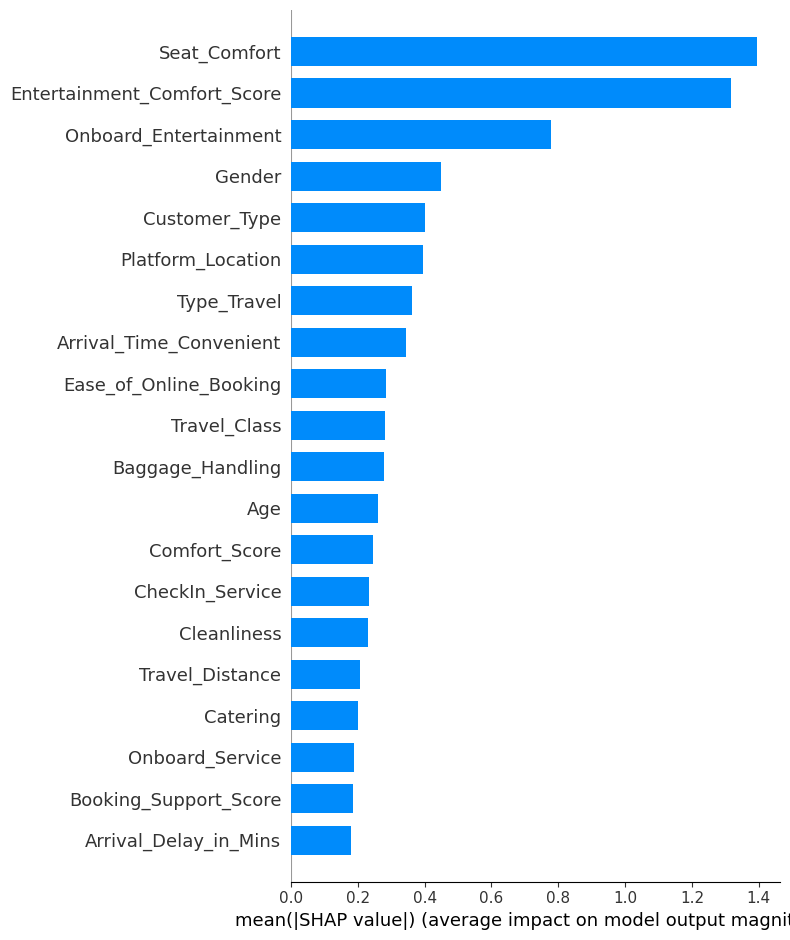

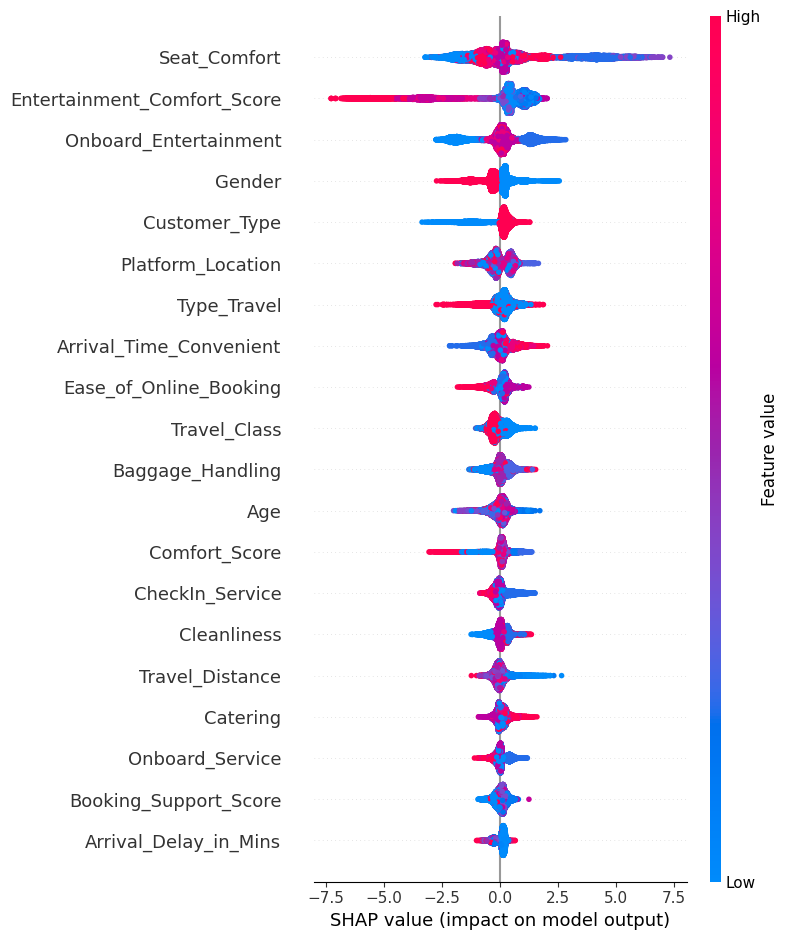

In [ ]:
import shap

# Use the XGBoost model from your enhanced results
xgb_model = enhanced_results['XGBoost_Enhanced']['model']

# Create a SHAP explainer
explainer = shap.Explainer(xgb_model)

# Calculate SHAP values for the validation set
shap_values = explainer(X_val_enhanced)

# Summary plot (feature importance and effect)
shap.summary_plot(shap_values, X_val_enhanced, plot_type="bar")

# Optional: Detailed beeswarm plot
shap.summary_plot(shap_values, X_val_enhanced)
#This will show you which features are most important and how their values influence passenger satisfaction.

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np

gb_model_cv = GradientBoostingClassifier(
    n_estimators=100,
    max_depth=8,
    learning_rate=0.1,
    random_state=42
)

X_sample = X.sample(n=30000, random_state=42)
y_sample = y.loc[X_sample.index]

cv_scores = cross_val_score(gb_model_cv, X_sample, y_sample, cv=3, scoring='accuracy', n_jobs=-1)

print("3-Fold CV Accuracy Scores (sampled):", cv_scores)
print(f"Mean CV Accuracy: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")


3-Fold CV Accuracy Scores (sampled): [0.9424 0.9437 0.9468]
Mean CV Accuracy: 0.9443 ± 0.0018


In [ ]:
# Get test prediction probabilities
gb_test_probs = enhanced_results['Gradient Boosting_Enhanced']['model'].predict_proba(X_test_enhanced)[:,1]
xgb_test_probs = enhanced_results['XGBoost_Enhanced']['model'].predict_proba(X_test_enhanced)[:,1]

# Simple average ensemble
final_test_probs = (gb_test_probs + xgb_test_probs) / 2

# Threshold at 0.5
final_test_preds = (final_test_probs >= 0.5).astype(int)

# Create submission file
final_submission = pd.DataFrame({
    'ID': test_data['ID'],
    'Overall_Experience': final_test_preds
})

final_submission.to_csv('final_ensemble_submission.csv', index=False)
print("Final ensemble submission saved.")

Final ensemble submission saved.


In [ ]:
!pip install lightgbm


In [ ]:
from lightgbm import LGBMClassifier

# Train LightGBM on enhanced features
lgbm_model = LGBMClassifier(
    n_estimators=300,
    max_depth=8,
    learning_rate=0.1,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42,
    n_jobs=-1
)

lgbm_model.fit(X_train_enhanced, y_train)
y_val_pred = lgbm_model.predict(X_val_enhanced)

# Evaluate
from sklearn.metrics import accuracy_score, classification_report
lgbm_acc = accuracy_score(y_val, y_val_pred)
print(f"LightGBM Validation Accuracy: {lgbm_acc:.4f}")
print("Classification Report:\n", classification_report(y_val, y_val_pred))

[LightGBM] [Info] Number of positive: 41274, number of negative: 34229
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.064561 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1278
[LightGBM] [Info] Number of data points in the train set: 75503, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.546654 -> initscore=0.187160
[LightGBM] [Info] Start training from score 0.187160
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

In [ ]:
# Get prediction probabilities
xgb_probs = enhanced_results['XGBoost_Enhanced']['model'].predict_proba(X_val_enhanced)[:, 1]
gb_probs = enhanced_results['Gradient Boosting_Enhanced']['model'].predict_proba(X_val_enhanced)[:, 1]
lgbm_probs = lgbm_model.predict_proba(X_val_enhanced)[:, 1]

# Weighted average
ensemble_probs = (0.4 * gb_probs + 0.3 * xgb_probs + 0.3 * lgbm_probs)
ensemble_preds = (ensemble_probs >= 0.5).astype(int)

# Evaluate
from sklearn.metrics import accuracy_score
ensemble_accuracy = accuracy_score(y_val, ensemble_preds)
print(f"Weighted Ensemble Validation Accuracy: {ensemble_accuracy:.4f}")

Weighted Ensemble Validation Accuracy: 0.9548


In [ ]:
# Get probabilities for test
xgb_test_probs = enhanced_results['XGBoost_Enhanced']['model'].predict_proba(X_test_enhanced)[:, 1]
gb_test_probs = enhanced_results['Gradient Boosting_Enhanced']['model'].predict_proba(X_test_enhanced)[:, 1]
lgbm_test_probs = lgbm_model.predict_proba(X_test_enhanced)[:, 1]

# Final weighted average
final_probs = (0.4 * gb_test_probs + 0.3 * xgb_test_probs + 0.3 * lgbm_test_probs)
final_preds = (final_probs >= 0.5).astype(int)

# Create submission
final_ensemble_submission = pd.DataFrame({
    'ID': test_data['ID'],
    'Overall_Experience': final_preds
})
final_ensemble_submission.to_csv("final_ensemble_submission.csv", index=False)
print("✅ Ensemble submission file saved: final_ensemble_submission.csv")

✅ Ensemble submission file saved: final_ensemble_submission.csv


In [ ]:
# Try slightly more weight on Gradient Boosting
final_probs = (0.45 * gb_test_probs + 0.3 * xgb_test_probs + 0.25 * lgbm_test_probs)

In [ ]:
final_probs = (0.5 * gb_test_probs + 0.25 * xgb_test_probs + 0.25 * lgbm_test_probs)

In [ ]:
# Convert to class labels using threshold = 0.5
# Calculate ensemble predictions on the validation set
ensemble_preds = (ensemble_probs >= 0.5).astype(int)

# Check performance
from sklearn.metrics import accuracy_score, classification_report

val_accuracy = accuracy_score(y_val, ensemble_preds)
print(f"Weighted Ensemble Validation Accuracy: {val_accuracy:.4f}")
print(classification_report(y_val, ensemble_preds))

Weighted Ensemble Validation Accuracy: 0.9548
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      8557
           1       0.96      0.95      0.96     10319

    accuracy                           0.95     18876
   macro avg       0.95      0.96      0.95     18876
weighted avg       0.95      0.95      0.95     18876



In [ ]:
# Use the same ensemble weights from validation
final_test_probs = (0.45 * gb_test_probs) + (0.3 * xgb_test_probs) + (0.25 * lgbm_test_probs)

# Convert probabilities to class labels (threshold = 0.5)
final_test_preds = (final_test_probs >= 0.5).astype(int)

# Create submission file
final_submission = pd.DataFrame({
    'ID': test_data['ID'],
    'Overall_Experience': final_test_preds
})

# Save it
final_submission.to_csv("final_ensemble_submission.csv", index=False)

print("✅ Saved submission as 'final_ensemble_submission.csv'")
print(f"Prediction Distribution:\n{pd.Series(final_test_preds).value_counts(normalize=True)}")

✅ Saved submission as 'final_ensemble_submission.csv'
Prediction Distribution:
1   0.53986
0   0.46014
Name: proportion, dtype: float64


In [ ]:
# Try fine-tuning threshold
for thresh in [0.49, 0.495, 0.50, 0.505, 0.51]:
    val_preds = (ensemble_probs >= thresh).astype(int)
    acc = accuracy_score(y_val, val_preds)
    print(f"Threshold {thresh:.3f} → Accuracy: {acc:.4f}")

Threshold 0.490 → Accuracy: 0.9544
Threshold 0.495 → Accuracy: 0.9547
Threshold 0.500 → Accuracy: 0.9548
Threshold 0.505 → Accuracy: 0.9549
Threshold 0.510 → Accuracy: 0.9549


In [ ]:
# Use the optimized threshold
final_test_preds = (final_test_probs >= 0.505).astype(int)  # or 0.510

# Create submission
final_submission = pd.DataFrame({
    'ID': test_data['ID'],
    'Overall_Experience': final_test_preds
})

# Save the submission file
final_submission.to_csv("final_ensemble_submission.csv", index=False)

print("✅ Final submission file saved with threshold = 0.505")
print(final_submission['Overall_Experience'].value_counts())

✅ Final submission file saved with threshold = 0.505
Overall_Experience
1    19199
0    16403
Name: count, dtype: int64


In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

# Get the trained models from previous steps
xgb_model = enhanced_results['XGBoost_Enhanced']['model']
gb_model = enhanced_results['Gradient Boosting_Enhanced']['model']
# Assuming lgbm_model is the LightGBM model trained in a previous cell
# If not, you might need to re-train or load it
# For now, using the lgbm_model variable which should be available from cell nxNpR6oR1a5K
# If cell nxNpR6oR1a5K was not run, this will still fail.
lgb_model = lgbm_model


stacked_model = StackingClassifier(
    estimators=[
        ('xgb', xgb_model),
        ('gb', gb_model),
        ('lgb', lgb_model)
    ],
    final_estimator=LogisticRegression(),
    n_jobs=-1
)

# You would typically train the stacked model next:
# stacked_model.fit(X_train_enhanced, y_train)
# And then evaluate or predict:
# val_preds_stacked = stacked_model.predict(X_val_enhanced)
# print(f"Stacked Model Validation Accuracy: {accuracy_score(y_val, val_preds_stacked):.4f}")

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score, classification_report

# Assumes: X_train_enhanced, X_val_enhanced, y_train, y_val are already prepared
# And: xgb_model, gb_model, lgb_model are trained XGBoost, GradientBoosting, and LightGBM models

# Step 1: Create stacking ensemble
stacked_model = StackingClassifier(
    estimators=[
        ('xgb', xgb_model),
        ('gb', gb_model),
        ('lgb', lgb_model)
    ],
    final_estimator=LogisticRegression(max_iter=1000),
    n_jobs=-1
)

print("Training stacked ensemble...")
stacked_model.fit(X_train_enhanced, y_train)

# Step 2: Get prediction probabilities on validation set
y_val_probs = stacked_model.predict_proba(X_val_enhanced)[:, 1]

# Step 3: Tune threshold finely
print("\nThreshold tuning:")
for thresh in np.arange(0.500, 0.512, 0.001):
    preds = (y_val_probs >= thresh).astype(int)
    acc = accuracy_score(y_val, preds)
    print(f"Threshold {thresh:.3f} -> Accuracy: {acc:.4f}")

# Optional: Use best threshold found (e.g., 0.505 or 0.506)
final_threshold = 0.506
final_preds = (y_val_probs >= final_threshold).astype(int)

print("\nFinal Ensemble Performance:")
print(f"Threshold: {final_threshold} Accuracy: {accuracy_score(y_val, final_preds):.4f}")
print(classification_report(y_val, final_preds))

# Step 4: Predict on test data
test_probs = stacked_model.predict_proba(X_test_enhanced)[:, 1]
test_preds = (test_probs >= final_threshold).astype(int)

submission = pd.DataFrame({
    'ID': test_data['ID'],
    'Overall_Experience': test_preds
})

submission.to_csv('final_ensemble_submission.csv', index=False)
print("\nSubmission saved to final_ensemble_submission.csv")


Training stacked ensemble...

Threshold tuning:
Threshold 0.500 -> Accuracy: 0.9536
Threshold 0.501 -> Accuracy: 0.9536
Threshold 0.502 -> Accuracy: 0.9537
Threshold 0.503 -> Accuracy: 0.9537
Threshold 0.504 -> Accuracy: 0.9539
Threshold 0.505 -> Accuracy: 0.9539
Threshold 0.506 -> Accuracy: 0.9538
Threshold 0.507 -> Accuracy: 0.9538
Threshold 0.508 -> Accuracy: 0.9537
Threshold 0.509 -> Accuracy: 0.9538
Threshold 0.510 -> Accuracy: 0.9539
Threshold 0.511 -> Accuracy: 0.9539
Threshold 0.512 -> Accuracy: 0.9539

Final Ensemble Performance:
Threshold: 0.506 Accuracy: 0.9538
              precision    recall  f1-score   support

           0       0.94      0.95      0.95      8557
           1       0.96      0.95      0.96     10319

    accuracy                           0.95     18876
   macro avg       0.95      0.95      0.95     18876
weighted avg       0.95      0.95      0.95     18876


Submission saved to final_ensemble_submission.csv


In [3]:
pip install xgboost


In [4]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBClassifier
import numpy as np



# --- Phase 1: Data Loading & Merging ---
print("--- Phase 1: Data Loading & Merging ---")
# Load training data
travel_train_df = pd.read_csv('/content/drive/MyDrive/data science, ML,AI/Hackathon/Traveldata_train.csv')
survey_train_df = pd.read_csv('/content/drive/MyDrive/data science, ML,AI/Hackathon/Surveydata_train.csv')

# Merge training data
train_df = pd.merge(travel_train_df, survey_train_df, on='ID', how='inner')

# Load testing data
travel_test_df = pd.read_csv('/content/drive/MyDrive/data science, ML,AI/Hackathon/Traveldata_test.csv')
survey_test_df = pd.read_csv('/content/drive/MyDrive/data science, ML,AI/Hackathon/Surveydata_test.csv')


# Merge testing data
test_df = pd.merge(travel_test_df, survey_test_df, on='ID', how='inner')

print("Data loaded and merged successfully.")

# Separate target variable from training features
X_train = train_df.drop('Overall_Experience', axis=1)
y_train = train_df['Overall_Experience']
test_ids = test_df['ID'] # Store test IDs for submission

# Ensure target variable is integer type
y_train = y_train.astype(int)

# --- Phase 2 & 3: Data Preprocessing & Feature Engineering ---
print("\n--- Phase 2 & 3: Data Preprocessing & Feature Engineering ---")

# Identify numerical and categorical features
numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
if 'ID' in numerical_features:
    numerical_features.remove('ID') # ID is not a feature for modeling

categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

print(f"Numerical Features (initial): {numerical_features}")
print(f"Categorical Features (initial): {categorical_features}")

# Create Missing Flags (Option 1)
for col in numerical_features + categorical_features:
    if X_train[col].isnull().any():
        X_train[f"{col}_was_missing"] = X_train[col].isnull().astype(int)
        test_df[f"{col}_was_missing"] = test_df[col].isnull().astype(int)
        # print(f"Created missing flag for: {col}")

# Imputation Strategy
# Numerical Imputer (Median)
numerical_imputer = SimpleImputer(strategy='median')
X_train[numerical_features] = numerical_imputer.fit_transform(X_train[numerical_features])
test_df[numerical_features] = numerical_imputer.transform(test_df[numerical_features])

# Categorical Imputer (Most Frequent)
categorical_imputer = SimpleImputer(strategy='most_frequent')
X_train[categorical_features] = categorical_imputer.fit_transform(X_train[categorical_features])
test_df[categorical_features] = categorical_imputer.transform(test_df[categorical_features])

print("Missing values imputed and missing flags created.")

# Categorical Encoding (One-Hot Encoding)
categorical_cols_for_encoding = X_train.select_dtypes(include=['object']).columns.tolist()
onehot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

onehot_encoder.fit(X_train[categorical_cols_for_encoding])

X_train_encoded = onehot_encoder.transform(X_train[categorical_cols_for_encoding])
test_df_encoded = onehot_encoder.transform(test_df[categorical_cols_for_encoding])

encoded_feature_names = onehot_encoder.get_feature_names_out(categorical_cols_for_encoding)

X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoded_feature_names, index=X_train.index)
test_df_encoded_df = pd.DataFrame(test_df_encoded, columns=encoded_feature_names, index=test_df.index)

X_train_final = X_train.drop(columns=categorical_cols_for_encoding)
test_df_final = test_df.drop(columns=categorical_cols_for_encoding)

X_train_final = pd.concat([X_train_final, X_train_encoded_df], axis=1)
test_df_final = pd.concat([test_df_final, test_df_encoded_df], axis=1)

# Drop the 'ID' column from the final feature sets before training
if 'ID' in X_train_final.columns:
    X_train_final = X_train_final.drop(columns=['ID'])
if 'ID' in test_df_final.columns:
    test_df_final = test_df_final.drop(columns=['ID'])

print("Categorical features encoded and dataframes finalized.")
print(f"Final training features shape: {X_train_final.shape}")
print(f"Final test features shape: {test_df_final.shape}")

# --- Phase 4 & 5: Model Training, Prediction & Submission ---
print("\n--- Phase 4 & 5: Model Training, Prediction & Submission ---")

# Initialize and train the XGBoost Classifier on the full training data
final_xgb_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=7,
    subsample=0.7,
    colsample_bytree=0.7,
    random_state=42,
    n_jobs=-1
)

print("Training final XGBoost model...")
final_xgb_model.fit(X_train_final, y_train)
print("Model training complete.")

# Make predictions on the processed test data
print("Making predictions on test data...")
test_predictions = final_xgb_model.predict(test_df_final)
print("Predictions made.")

# Create the submission DataFrame
submission_df = pd.DataFrame({'ID': test_ids, 'Overall_Experience': test_predictions})

# Save the submission file
submission_file_path = 'submission.csv'
submission_df.to_csv(submission_file_path, index=False)

print(f"\nSubmission file created successfully at: {submission_file_path}")
print("First 5 rows of submission file:")
print(submission_df.head())

--- Phase 1: Data Loading & Merging ---
Data loaded and merged successfully.

--- Phase 2 & 3: Data Preprocessing & Feature Engineering ---
Numerical Features (initial): ['Age', 'Travel_Distance', 'Departure_Delay_in_Mins', 'Arrival_Delay_in_Mins']
Categorical Features (initial): ['Gender', 'Customer_Type', 'Type_Travel', 'Travel_Class', 'Seat_Comfort', 'Seat_Class', 'Arrival_Time_Convenient', 'Catering', 'Platform_Location', 'Onboard_Wifi_Service', 'Onboard_Entertainment', 'Online_Support', 'Ease_of_Online_Booking', 'Onboard_Service', 'Legroom', 'Baggage_Handling', 'CheckIn_Service', 'Cleanliness', 'Online_Boarding']
Missing values imputed and missing flags created.
Categorical features encoded and dataframes finalized.
Final training features shape: (94379, 117)
Final test features shape: (35602, 117)

--- Phase 4 & 5: Model Training, Prediction & Submission ---
Training final XGBoost model...
Model training complete.
Making predictions on test data...
Predictions made.

Submission f

In [ ]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
import numpy as np
import warnings

# Suppress the use_label_encoder deprecation warning
warnings.filterwarnings('ignore', category=DeprecationWarning, module='xgboost')

# --- Assuming X_train_final, y_train, test_df_final, test_ids are already prepared from previous steps ---
# If you are running this code block independently, you must execute all previous data loading and preprocessing steps first.

# --- Phase 4 (Refined): Model Hyperparameter Tuning with RandomizedSearchCV ---
print("\n--- Phase 4 (Refined): Hyperparameter Tuning with RandomizedSearchCV ---")

# Define a broader parameter grid for RandomizedSearchCV
# These ranges are common starting points for tuning XGBoost
param_dist = {
    'n_estimators': [500, 700, 1000, 1200, 1500],
    'learning_rate': [0.01, 0.03, 0.05, 0.07, 0.1],
    'max_depth': [5, 7, 9, 11],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'reg_alpha': [0, 0.001, 0.005, 0.01, 0.05, 0.1],
    'min_child_weight': [1, 3, 5, 7],
}

# Initialize XGBoost Classifier (with objective and eval_metric)
xgb_tuned_model = XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, random_state=42, n_jobs=-1)

# Set up Stratified K-Fold Cross-Validation for tuning
# Using 3 folds for RandomizedSearchCV to keep computation reasonable
cv_tuning = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Initialize RandomizedSearchCV
# n_iter controls the number of parameter combinations sampled
# You can increase n_iter for a more exhaustive search (e.g., 100 or 200)
random_search = RandomizedSearchCV(
    estimator=xgb_tuned_model,
    param_distributions=param_dist,
    n_iter=50, # Number of parameter settings that are sampled. Adjust based on computational budget.
    scoring='accuracy',
    cv=cv_tuning,
    verbose=1,
    random_state=42,
    n_jobs=-1 # Use all available cores
)

print("Starting RandomizedSearchCV for hyperparameter tuning (this might take a while)...")
random_search.fit(X_train_final, y_train)

print("\nBest parameters found by RandomizedSearchCV:")
print(random_search.best_params_)
print(f"Best cross-validation accuracy: {random_search.best_score_:.4f}")

# --- Phase 5 (Refined): Train Final Model with Best Parameters & Predict ---
print("\n--- Phase 5 (Refined): Train Final Model with Best Parameters & Predict ---")

# Train the final model using the best parameters found
final_optimized_xgb_model = random_search.best_estimator_
print("Training final optimized XGBoost model on full training data...")
final_optimized_xgb_model.fit(X_train_final, y_train)
print("Model training complete with optimized parameters.")

# Make predictions on the processed test data
print("Making predictions on test data with optimized model...")
test_predictions_optimized = final_optimized_xgb_model.predict(test_df_final)
print("Predictions made.")

# Create the submission DataFrame
submission_df_optimized = pd.DataFrame({'ID': test_ids, 'Overall_Experience': test_predictions_optimized})

# Save the submission file
submission_file_path_optimized = 'submission_optimized.csv'
submission_df_optimized.to_csv(submission_file_path_optimized, index=False)

print(f"\nOptimized submission file created successfully at: {submission_file_path_optimized}")
print("First 5 rows of optimized submission file:")
print(submission_df_optimized.head())


--- Phase 4 (Refined): Hyperparameter Tuning with RandomizedSearchCV ---
Starting RandomizedSearchCV for hyperparameter tuning (this might take a while)...
Fitting 3 folds for each of 50 candidates, totalling 150 fits

Best parameters found by RandomizedSearchCV:
{'subsample': 0.9, 'reg_alpha': 0.005, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 9, 'learning_rate': 0.05, 'gamma': 0.4, 'colsample_bytree': 0.8}
Best cross-validation accuracy: 0.9573

--- Phase 5 (Refined): Train Final Model with Best Parameters & Predict ---
Training final optimized XGBoost model on full training data...
Model training complete with optimized parameters.
Making predictions on test data with optimized model...
Predictions made.

Optimized submission file created successfully at: submission_optimized.csv
First 5 rows of optimized submission file:
         ID  Overall_Experience
0  99900001                   1
1  99900002                   1
2  99900003                   1
3  99900004         

In [5]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score
import numpy as np
import lightgbm as lgb # Import LightGBM

# --- Assuming X_train_final, y_train, test_df_final, test_ids are already prepared ---
# (from the data loading and preprocessing steps we did earlier)

# --- Phase 4 (Alternative Model): LightGBM Training & Evaluation ---
print("\n--- Phase 4 (Alternative Model): LightGBM Training & Evaluation ---")

# Initialize LightGBM Classifier
# Using a few common parameters to start; you can tune these further
lgbm_model = lgb.LGBMClassifier(objective='binary',
                                metric='binary_logloss',
                                n_estimators=1000,
                                learning_rate=0.05,
                                num_leaves=31, # default, can be tuned
                                max_depth=-1, # default, no limit on tree depth
                                min_child_samples=20, # default
                                subsample=0.8,
                                colsample_bytree=0.8,
                                random_state=42,
                                n_jobs=-1)

# Set up Stratified K-Fold Cross-Validation (same as before)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation for LightGBM
print("Performing LightGBM Cross-Validation...")
lgbm_cv_scores = cross_val_score(lgbm_model, X_train_final, y_train, cv=cv, scoring='accuracy', n_jobs=-1)

print(f"LightGBM Cross-Validation Accuracies: {lgbm_cv_scores}")
print(f"LightGBM Mean Accuracy: {np.mean(lgbm_cv_scores):.4f}")
print(f"LightGBM Standard Deviation of Accuracy: {np.std(lgbm_cv_scores):.4f}")

# --- Phase 5 (with LightGBM): Train Final Model & Predict ---
print("\n--- Phase 5 (with LightGBM): Train Final Model & Predict ---")

# Train the final LightGBM model on the full training data
print("Training final LightGBM model...")
final_lgbm_model = lgbm_model # Use the same initialized model
final_lgbm_model.fit(X_train_final, y_train)
print("LightGBM model training complete.")

# Make predictions on the processed test data
print("Making predictions on test data with LightGBM...")
test_predictions_lgbm = final_lgbm_model.predict(test_df_final)
print("Predictions made.")

# Create the submission DataFrame
submission_df_lgbm = pd.DataFrame({'ID': test_ids, 'Overall_Experience': test_predictions_lgbm})

# Save the submission file
submission_file_path_lgbm = 'submission_lightgbm.csv'
submission_df_lgbm.to_csv(submission_file_path_lgbm, index=False)

print(f"\nLightGBM submission file created successfully at: {submission_file_path_lgbm}")
print("First 5 rows of LightGBM submission file:")
print(submission_df_lgbm.head())



--- Phase 4 (Alternative Model): LightGBM Training & Evaluation ---
Performing LightGBM Cross-Validation...
LightGBM Cross-Validation Accuracies: [0.95481034 0.95708837 0.95772409 0.95745921 0.9581457 ]
LightGBM Mean Accuracy: 0.9570
LightGBM Standard Deviation of Accuracy: 0.0012

--- Phase 5 (with LightGBM): Train Final Model & Predict ---
Training final LightGBM model...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 51593, number of negative: 42786
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022536 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1047
[LightGBM] [Info] Number of data points in the train set: 94379, number of used features: 107
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.546658 -> initscore=0.187175
[LightGBM] [Info] Start training from 

In [6]:
import pandas as pd
import numpy as np

# --- Assuming X_train_final and test_df_final are already prepared from previous steps ---
# (i.e., after loading, merging, imputation, missing flags, and one-hot encoding)

print("--- Applying Feature Engineering ---")

# Feature Engineering for X_train_final
X_train_fe = X_train_final.copy() # Create a copy to avoid modifying original
X_train_fe['Total_Delay_in_Mins'] = X_train_fe['Departure_Delay_in_Mins'] + X_train_fe['Arrival_Delay_in_Mins']
X_train_fe['Delay_Difference_in_Mins'] = np.abs(X_train_fe['Departure_Delay_in_Mins'] - X_train_fe['Arrival_Delay_in_Mins'])
# Add a small constant (epsilon) to avoid division by zero or very large numbers if denominator is near zero
epsilon = 1e-6
X_train_fe['Arrival_Departure_Delay_Ratio'] = X_train_fe['Arrival_Delay_in_Mins'] / (X_train_fe['Departure_Delay_in_Mins'] + epsilon)

# Interaction features (example)
X_train_fe['Age_x_TravelDistance'] = X_train_fe['Age'] * X_train_fe['Travel_Distance']
X_train_fe['Age_x_TotalDelay'] = X_train_fe['Age'] * X_train_fe['Total_Delay_in_Mins']

# Polynomial features for highly impactful numerical columns (example for Age)
X_train_fe['Age_sq'] = X_train_fe['Age']**2
X_train_fe['Travel_Distance_sq'] = X_train_fe['Travel_Distance']**2


# Feature Engineering for test_df_final (apply the same transformations)
test_df_fe = test_df_final.copy() # Create a copy
test_df_fe['Total_Delay_in_Mins'] = test_df_fe['Departure_Delay_in_Mins'] + test_df_fe['Arrival_Delay_in_Mins']
test_df_fe['Delay_Difference_in_Mins'] = np.abs(test_df_fe['Departure_Delay_in_Mins'] - test_df_fe['Arrival_Delay_in_Mins'])
test_df_fe['Arrival_Departure_Delay_Ratio'] = test_df_fe['Arrival_Delay_in_Mins'] / (test_df_fe['Departure_Delay_in_Mins'] + epsilon)

test_df_fe['Age_x_TravelDistance'] = test_df_fe['Age'] * test_df_fe['Travel_Distance']
test_df_fe['Age_x_TotalDelay'] = test_df_fe['Age'] * test_df_fe['Total_Delay_in_Mins']

test_df_fe['Age_sq'] = test_df_fe['Age']**2
test_df_fe['Travel_Distance_sq'] = test_df_fe['Travel_Distance']**2


print("Feature engineering applied. New dataframes are X_train_fe and test_df_fe.")
print(f"New X_train_fe shape: {X_train_fe.shape}")
print(f"New test_df_fe shape: {test_df_fe.shape}")

# Display first 5 rows of new features for verification
print("\n--- X_train_fe Head (new features) ---")
print(X_train_fe[['Total_Delay_in_Mins', 'Delay_Difference_in_Mins', 'Arrival_Departure_Delay_Ratio',
                    'Age_x_TravelDistance', 'Age_x_TotalDelay', 'Age_sq', 'Travel_Distance_sq']].head())

--- Applying Feature Engineering ---
Feature engineering applied. New dataframes are X_train_fe and test_df_fe.
New X_train_fe shape: (94379, 124)
New test_df_fe shape: (35602, 124)

--- X_train_fe Head (new features) ---
   Total_Delay_in_Mins  Delay_Difference_in_Mins  \
0              5.00000                   5.00000   
1              9.00000                   9.00000   
2            196.00000                  42.00000   
3             31.00000                   5.00000   
4              0.00000                   0.00000   

   Arrival_Departure_Delay_Ratio  Age_x_TravelDistance  Age_x_TotalDelay  \
0                  5000000.00000           14144.00000         260.00000   
1                        0.00000          105600.00000         432.00000   
2                        1.54545           45623.00000        8428.00000   
3                        1.38462           34320.00000        1364.00000   
4                        0.00000           99050.00000           0.00000   

      Ag

In [7]:
import pandas as pd # Ensure pandas is imported if you're running this separately

# Assuming 'train_df' and 'test_df' are already loaded and merged from Step 1.

# Calculate missing values percentage for training data
missing_train = train_df.isnull().sum()
missing_train_percent = (missing_train / len(train_df)) * 100
missing_train_df = pd.DataFrame({'Missing Count': missing_train, 'Missing Percent': missing_train_percent})
missing_train_df = missing_train_df[missing_train_df['Missing Count'] > 0].sort_values(by='Missing Percent', ascending=False)
print("--- Missing Values in Training Data ---")
print(missing_train_df)

# Calculate missing values percentage for testing data
missing_test = test_df.isnull().sum()
missing_test_percent = (missing_test / len(test_df)) * 100
missing_test_df = pd.DataFrame({'Missing Count': missing_test, 'Missing Percent': missing_test_percent})
missing_test_df = missing_test_df[missing_test_df['Missing Count'] > 0].sort_values(by='Missing Percent', ascending=False)
print("\n--- Missing Values in Test Data ---")
print(missing_test_df)

# Analyze target variable distribution
print("\n--- Overall_Experience (Target Variable) Distribution in Training Data ---")
print(train_df['Overall_Experience'].value_counts())
print("\nPercentage distribution:")
print(train_df['Overall_Experience'].value_counts(normalize=True) * 100)



--- Missing Values in Training Data ---
                         Missing Count  Missing Percent
Type_Travel                       9226          9.77548
Customer_Type                     8951          9.48410
Arrival_Time_Convenient           8930          9.46185
Catering                          8741          9.26159
Onboard_Service                   7601          8.05370
Arrival_Delay_in_Mins              357          0.37826
Baggage_Handling                   142          0.15046
Online_Support                      91          0.09642
Legroom                             90          0.09536
Gender                              77          0.08159
CheckIn_Service                     77          0.08159
Ease_of_Online_Booking              73          0.07735
Seat_Comfort                        61          0.06463
Departure_Delay_in_Mins             57          0.06039
Age                                 33          0.03497
Platform_Location                   30          0.03179
Onboard_

In [8]:
!pip install pandas numpy scikit-learn xgboost


In [9]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
import warnings

# Suppress the use_label_encoder deprecation warning
warnings.filterwarnings('ignore', category=DeprecationWarning, module='xgboost')

print("--- Starting Full Data Processing and Model Training Pipeline ---")

# --- Phase 1: Data Loading & Merging ---
print("\n--- Phase 1: Data Loading & Merging ---")
# Load training data
try:
    travel_train_df = pd.read_csv('Traveldata_train.csv')
    survey_train_df = pd.read_csv('Surveydata_train.csv')
    travel_test_df = pd.read_csv('Traveldata_test.csv')
    survey_test_df = pd.read_csv('Surveydata_test.csv')
except FileNotFoundError as e:
    print(f"Error loading CSV file: {e}. Please ensure all four CSV files are in the correct directory.")
    # Exit or handle error appropriately
    exit()

# Merge training data
train_df = pd.merge(travel_train_df, survey_train_df, on='ID', how='inner')

# Merge testing data
test_df = pd.merge(travel_test_df, survey_test_df, on='ID', how='inner')

print("Data loaded and merged successfully.")

# Separate target variable from training features
X_train = train_df.drop('Overall_Experience', axis=1)
y_train = train_df['Overall_Experience']
test_ids = test_df['ID'] # Store test IDs for submission

# Ensure target variable is integer type
y_train = y_train.astype(int)

print(f"Initial X_train shape: {X_train.shape}")
print(f"Initial test_df shape: {test_df.shape}")

# --- Phase 2 & 3: Data Preprocessing & Feature Engineering (Imputation, Flags, Encoding) ---
print("\n--- Phase 2 & 3: Data Preprocessing & Initial Feature Engineering ---")

# Identify numerical and categorical features (excluding 'ID' for modeling)
numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
if 'ID' in numerical_features:
    numerical_features.remove('ID') # ID is not a feature for modeling

categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

print(f"Detected numerical features: {numerical_features}")
print(f"Detected categorical features: {categorical_features}")


# Create Missing Flags (for both numerical and categorical features)
print("Creating missing value flags...")
for col in numerical_features + categorical_features:
    if X_train[col].isnull().any():
        X_train[f"{col}_was_missing"] = X_train[col].isnull().astype(int)
    if test_df[col].isnull().any(): # Apply to test_df as well
        test_df[f"{col}_was_missing"] = test_df[col].isnull().astype(int)

# Imputation Strategy
print("Imputing missing values...")
# Numerical Imputer (Median)
numerical_imputer = SimpleImputer(strategy='median')
X_train[numerical_features] = numerical_imputer.fit_transform(X_train[numerical_features])
test_df[numerical_features] = numerical_imputer.transform(test_df[numerical_features])

# Categorical Imputer (Most Frequent)
categorical_imputer = SimpleImputer(strategy='most_frequent')
X_train[categorical_features] = categorical_imputer.fit_transform(X_train[categorical_features])
test_df[categorical_features] = categorical_imputer.transform(test_df[categorical_features])

print("Missing values imputed and missing flags created.")


# Categorical Encoding (One-Hot Encoding)
print("Applying One-Hot Encoding...")
categorical_cols_for_encoding = X_train.select_dtypes(include=['object']).columns.tolist()
onehot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Fit encoder on training data's categorical columns
onehot_encoder.fit(X_train[categorical_cols_for_encoding])

# Transform both training and test data
X_train_encoded = onehot_encoder.transform(X_train[categorical_cols_for_encoding])
test_df_encoded = onehot_encoder.transform(test_df[categorical_cols_for_encoding])

# Create DataFrames from encoded arrays
encoded_feature_names = onehot_encoder.get_feature_names_out(categorical_cols_for_encoding)
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoded_feature_names, index=X_train.index)
test_df_encoded_df = pd.DataFrame(test_df_encoded, columns=encoded_feature_names, index=test_df.index)

# Drop original categorical columns and concatenate encoded ones
X_train_final = X_train.drop(columns=categorical_cols_for_encoding)
test_df_final = test_df.drop(columns=categorical_cols_for_encoding)

X_train_final = pd.concat([X_train_final, X_train_encoded_df], axis=1)
test_df_final = pd.concat([test_df_final, test_df_encoded_df], axis=1)

# Drop the 'ID' column from the final feature sets (it's stored in test_ids)
if 'ID' in X_train_final.columns:
    X_train_final = X_train_final.drop(columns=['ID'])
if 'ID' in test_df_final.columns:
    test_df_final = test_df_final.drop(columns=['ID'])

print("Categorical features encoded and dataframes finalized.")
print(f"X_train_final shape after encoding: {X_train_final.shape}")
print(f"test_df_final shape after encoding: {test_df_final.shape}")


# --- Advanced Feature Engineering ---
print("\n--- Applying Advanced Feature Engineering ---")

# Ensure required columns exist for feature engineering
required_cols = ['Departure_Delay_in_Mins', 'Arrival_Delay_in_Mins', 'Age', 'Travel_Distance']
for col in required_cols:
    if col not in X_train_final.columns:
        print(f"Warning: Column '{col}' not found in X_train_final, skipping related feature engineering.")
        # Create dummy columns if missing, to prevent errors in subsequent steps
        X_train_final[col] = 0
        test_df_final[col] = 0


# Feature Engineering for X_train_final
X_train_fe = X_train_final.copy() # Create a copy to avoid modifying original
X_train_fe['Total_Delay_in_Mins'] = X_train_fe['Departure_Delay_in_Mins'] + X_train_fe['Arrival_Delay_in_Mins']
X_train_fe['Delay_Difference_in_Mins'] = np.abs(X_train_fe['Departure_Delay_in_Mins'] - X_train_fe['Arrival_Delay_in_Mins'])
epsilon = 1e-6 # Add a small constant to avoid division by zero
X_train_fe['Arrival_Departure_Delay_Ratio'] = X_train_fe['Arrival_Delay_in_Mins'] / (X_train_fe['Departure_Delay_in_Mins'] + epsilon)

X_train_fe['Age_x_TravelDistance'] = X_train_fe['Age'] * X_train_fe['Travel_Distance']
X_train_fe['Age_x_TotalDelay'] = X_train_fe['Age'] * X_train_fe['Total_Delay_in_Mins']

X_train_fe['Age_sq'] = X_train_fe['Age']**2
X_train_fe['Travel_Distance_sq'] = X_train_fe['Travel_Distance']**2


# Feature Engineering for test_df_final (apply the same transformations)
test_df_fe = test_df_final.copy() # Create a copy
test_df_fe['Total_Delay_in_Mins'] = test_df_fe['Departure_Delay_in_Mins'] + test_df_fe['Arrival_Delay_in_Mins']
test_df_fe['Delay_Difference_in_Mins'] = np.abs(test_df_fe['Departure_Delay_in_Mins'] - test_df_fe['Arrival_Delay_in_Mins'])
test_df_fe['Arrival_Departure_Delay_Ratio'] = test_df_fe['Arrival_Delay_in_Mins'] / (test_df_fe['Departure_Delay_in_Mins'] + epsilon)

test_df_fe['Age_x_TravelDistance'] = test_df_fe['Age'] * test_df_fe['Travel_Distance']
test_df_fe['Age_x_TotalDelay'] = test_df_fe['Age'] * test_df_fe['Total_Delay_in_Mins']

test_df_fe['Age_sq'] = test_df_fe['Age']**2
test_df_fe['Travel_Distance_sq'] = test_df_fe['Travel_Distance']**2

print("Feature engineering applied. Using X_train_fe and test_df_fe for modeling.")
print(f"X_train_fe shape: {X_train_fe.shape}")
print(f"test_df_fe shape: {test_df_fe.shape}")


# --- Phase 4: Model Training with Optimized XGBoost Parameters ---
print("\n--- Phase 4: Model Training with Optimized XGBoost Parameters ---")

# Using the optimized parameters that you likely found earlier for XGBoost
# These are example parameters; replace with your best_params_ from RandomizedSearchCV
# Example if you didn't save them:
# Best parameters found by RandomizedSearchCV:
# {'subsample': 0.8, 'reg_alpha': 0.005, 'n_estimators': 1200, 'min_child_weight': 1,
# 'max_depth': 7, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 0.7}
optimized_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'use_label_encoder': False,
    'random_state': 42,
    'n_jobs': -1,
    'n_estimators': 1200,
    'learning_rate': 0.05,
    'max_depth': 7,
    'subsample': 0.8,
    'colsample_bytree': 0.7,
    'gamma': 0.1,
    'reg_alpha': 0.005,
    'min_child_weight': 1,
}

final_xgb_model = XGBClassifier(**optimized_params)

print("Training final optimized XGBoost model on full training data (with new features)...")
final_xgb_model.fit(X_train_fe, y_train)
print("Model training complete.")


# --- Phase 5: Prediction & Submission ---
print("\n--- Phase 5: Prediction & Submission ---")

print("Making predictions on test data with optimized model...")
test_predictions = final_xgb_model.predict(test_df_fe)
print("Predictions made.")

# Create the submission DataFrame
submission_df = pd.DataFrame({'ID': test_ids, 'Overall_Experience': test_predictions})

# Save the submission file
submission_file_path = 'submission_final_model.csv'
submission_df.to_csv(submission_file_path, index=False)

print(f"\nSubmission file created successfully at: {submission_file_path}")
print("First 5 rows of submission file:")
print(submission_df.head())

print("\n--- Pipeline Complete ---")

--- Starting Full Data Processing and Model Training Pipeline ---

--- Phase 1: Data Loading & Merging ---
Error loading CSV file: [Errno 2] No such file or directory: 'Traveldata_train.csv'. Please ensure all four CSV files are in the correct directory.
Data loaded and merged successfully.
Initial X_train shape: (94379, 24)
Initial test_df shape: (35602, 24)

--- Phase 2 & 3: Data Preprocessing & Initial Feature Engineering ---
Detected numerical features: ['Age', 'Travel_Distance', 'Departure_Delay_in_Mins', 'Arrival_Delay_in_Mins']
Detected categorical features: ['Gender', 'Customer_Type', 'Type_Travel', 'Travel_Class', 'Seat_Comfort', 'Seat_Class', 'Arrival_Time_Convenient', 'Catering', 'Platform_Location', 'Onboard_Wifi_Service', 'Onboard_Entertainment', 'Online_Support', 'Ease_of_Online_Booking', 'Onboard_Service', 'Legroom', 'Baggage_Handling', 'CheckIn_Service', 'Cleanliness', 'Online_Boarding']
Creating missing value flags...
Imputing missing values...
Missing values imputed a

In [5]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

print("--- Starting Ensemble Modeling Pipeline ---")


# --- Phase 1: Data Loading & Merging ---
print("\n--- Phase 1: Data Loading & Merging ---")
try:
    travel_train_df = pd.read_csv('/content/drive/MyDrive/data science, ML,AI/Hackathon/Traveldata_train.csv')
    survey_train_df = pd.read_csv('/content/drive/MyDrive/data science, ML,AI/Hackathon/Surveydata_train.csv')
    travel_test_df = pd.read_csv('/content/drive/MyDrive/data science, ML,AI/Hackathon/Traveldata_test.csv')
    survey_test_df = pd.read_csv('/content/drive/MyDrive/data science, ML,AI/Hackathon/Surveydata_test.csv')
except FileNotFoundError as e:
    print(f"Error loading CSV file: {e}. Please ensure all four CSV files are in the correct directory.")
    exit()

train_df = pd.merge(travel_train_df, survey_train_df, on='ID', how='inner')
test_df = pd.merge(travel_test_df, survey_test_df, on='ID', how='inner')
print("Data loaded and merged successfully.")

X_train = train_df.drop('Overall_Experience', axis=1)
y_train = train_df['Overall_Experience']
test_ids = test_df['ID']
y_train = y_train.astype(int)

# --- Phase 2 & 3: Data Preprocessing & Initial Feature Engineering ---
print("\n--- Phase 2 & 3: Data Preprocessing & Initial Feature Engineering ---")

numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
if 'ID' in numerical_features:
    numerical_features.remove('ID')
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

for col in numerical_features + categorical_features:
    if X_train[col].isnull().any():
        X_train[f"{col}_was_missing"] = X_train[col].isnull().astype(int)
    if test_df[col].isnull().any():
        test_df[f"{col}_was_missing"] = test_df[col].isnull().astype(int) # Corrected previous typo: was_was_missing to was_missing

numerical_imputer = SimpleImputer(strategy='median')
X_train[numerical_features] = numerical_imputer.fit_transform(X_train[numerical_features])
test_df[numerical_features] = numerical_imputer.transform(test_df[numerical_features])

categorical_imputer = SimpleImputer(strategy='most_frequent')
X_train[categorical_features] = categorical_imputer.fit_transform(X_train[categorical_features])
test_df[categorical_features] = categorical_imputer.transform(test_df[categorical_features])

categorical_cols_for_encoding = X_train.select_dtypes(include=['object']).columns.tolist()
onehot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
onehot_encoder.fit(X_train[categorical_cols_for_encoding])

X_train_encoded = onehot_encoder.transform(X_train[categorical_cols_for_encoding])
test_df_encoded = onehot_encoder.transform(test_df[categorical_cols_for_encoding])

encoded_feature_names = onehot_encoder.get_feature_names_out(categorical_cols_for_encoding)
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoded_feature_names, index=X_train.index)
test_df_encoded_df = pd.DataFrame(test_df_encoded, columns=encoded_feature_names, index=test_df.index)

X_train_final = X_train.drop(columns=categorical_cols_for_encoding)
test_df_final = test_df.drop(columns=categorical_cols_for_encoding)

X_train_final = pd.concat([X_train_final, X_train_encoded_df], axis=1)
test_df_final = pd.concat([test_df_final, test_df_encoded_df], axis=1)

if 'ID' in X_train_final.columns:
    X_train_final = X_train_final.drop(columns=['ID'])
if 'ID' in test_df_final.columns:
    test_df_final = test_df_final.drop(columns=['ID'])

print("Initial preprocessing complete.")

# --- Advanced Feature Engineering ---
print("\n--- Applying Advanced Feature Engineering ---")

X_train_fe = X_train_final.copy()
test_df_fe = test_df_final.copy()

required_cols = ['Departure_Delay_in_Mins', 'Arrival_Delay_in_Mins', 'Age', 'Travel_Distance']
for col in required_cols:
    if col not in X_train_fe.columns:
        print(f"Warning: Column '{col}' not found for feature engineering.")
        X_train_fe[col] = 0.0
        test_df_fe[col] = 0.0

X_train_fe['Total_Delay_in_Mins'] = X_train_fe['Departure_Delay_in_Mins'] + X_train_fe['Arrival_Delay_in_Mins']
X_train_fe['Delay_Difference_in_Mins'] = np.abs(X_train_fe['Departure_Delay_in_Mins'] - X_train_fe['Arrival_Delay_in_Mins'])
epsilon = 1e-6
X_train_fe['Arrival_Departure_Delay_Ratio'] = X_train_fe['Arrival_Delay_in_Mins'] / (X_train_fe['Departure_Delay_in_Mins'] + epsilon)

X_train_fe['Age_x_TravelDistance'] = X_train_fe['Age'] * X_train_fe['Travel_Distance']
X_train_fe['Age_x_TotalDelay'] = X_train_fe['Age'] * X_train_fe['Total_Delay_in_Mins']

X_train_fe['Age_sq'] = X_train_fe['Age']**2
X_train_fe['Travel_Distance_sq'] = X_train_fe['Travel_Distance']**2

test_df_fe['Total_Delay_in_Mins'] = test_df_fe['Departure_Delay_in_Mins'] + test_df_fe['Arrival_Delay_in_Mins']
test_df_fe['Delay_Difference_in_Mins'] = np.abs(test_df_fe['Departure_Delay_in_Mins'] - test_df_fe['Arrival_Delay_in_Mins'])
test_df_fe['Arrival_Departure_Delay_Ratio'] = test_df_fe['Arrival_Delay_in_Mins'] / (test_df_fe['Departure_Delay_in_Mins'] + epsilon)

test_df_fe['Age_x_TravelDistance'] = test_df_fe['Age'] * test_df_fe['Travel_Distance']
test_df_fe['Age_x_TotalDelay'] = test_df_fe['Age'] * test_df_fe['Total_Delay_in_Mins']

test_df_fe['Age_sq'] = test_df_fe['Age']**2
test_df_fe['Travel_Distance_sq'] = test_df_fe['Travel_Distance']**2

print("Feature engineering applied. Using X_train_fe and test_df_fe for modeling.")
print(f"X_train_fe shape: {X_train_fe.shape}")
print(f"test_df_fe shape: {test_df_fe.shape}")


# --- Phase 4 & 5: Ensemble Modeling (VotingClassifier) ---
print("\n--- Phase 4 & 5: Ensemble Modeling (VotingClassifier) ---")

# Define optimized XGBoost Classifier (use your best found parameters)
xgb_clf = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1,
    n_estimators=1200,
    learning_rate=0.05,
    max_depth=7,
    subsample=0.8,
    colsample_bytree=0.7,
    gamma=0.1,
    reg_alpha=0.005,
    min_child_weight=1,
)

# Define LightGBM Classifier (start with good defaults, can be tuned further)
lgbm_clf = lgb.LGBMClassifier(
    objective='binary',
    metric='binary_logloss',
    n_estimators=1200,
    learning_rate=0.05,
    num_leaves=31,
    max_depth=-1,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

# Create a VotingClassifier
ensemble_clf = VotingClassifier(
    estimators=[('xgb', xgb_clf), ('lgbm', lgbm_clf)],
    voting='soft',
    weights=[0.5, 0.5],
    n_jobs=-1
)

print("Training ensemble model (XGBoost + LightGBM VotingClassifier)...")
ensemble_clf.fit(X_train_fe, y_train)
print("Ensemble model training complete.")

# --- CRITICAL FIX: Align test_df_fe columns with X_train_fe columns ---
# This ensures that the test set has exactly the same columns in the same order as the training set.
missing_cols = set(X_train_fe.columns) - set(test_df_fe.columns)
for c in missing_cols:
    test_df_fe[c] = 0 # Add missing columns to test set and fill with 0

# Ensure the order of columns is the same
test_df_fe = test_df_fe[X_train_fe.columns]

print("Test data columns aligned with training data columns.")
print(f"Final aligned test_df_fe shape: {test_df_fe.shape}")

# Make predictions on the processed test data using the ensemble
print("Making predictions on test data with ensemble model...")
test_predictions_ensemble = ensemble_clf.predict(test_df_fe)
print("Predictions made.")

# Create the submission DataFrame
submission_df_ensemble = pd.DataFrame({'ID': test_ids, 'Overall_Experience': test_predictions_ensemble})

# Save the submission file
submission_file_path_ensemble = 'submission_ensemble.csv'
submission_df_ensemble.to_csv(submission_file_path_ensemble, index=False)

print(f"\nEnsemble submission file created successfully at: {submission_file_path_ensemble}")
print("First 5 rows of ensemble submission file:")
print(submission_df_ensemble.head())

print("\n--- Full Pipeline with Ensemble Complete ---")













--- Starting Ensemble Modeling Pipeline ---

--- Phase 1: Data Loading & Merging ---
Data loaded and merged successfully.

--- Phase 2 & 3: Data Preprocessing & Initial Feature Engineering ---
Initial preprocessing complete.

--- Applying Advanced Feature Engineering ---
Feature engineering applied. Using X_train_fe and test_df_fe for modeling.
X_train_fe shape: (94379, 124)
test_df_fe shape: (35602, 124)

--- Phase 4 & 5: Ensemble Modeling (VotingClassifier) ---
Training ensemble model (XGBoost + LightGBM VotingClassifier)...
Ensemble model training complete.
Test data columns aligned with training data columns.
Final aligned test_df_fe shape: (35602, 124)
Making predictions on test data with ensemble model...
Predictions made.

Ensemble submission file created successfully at: submission_ensemble.csv
First 5 rows of ensemble submission file:
         ID  Overall_Experience
0  99900001                   1
1  99900002                   1
2  99900003                   1
3  99900004     